## Logistic Regression in PySpark

**Import dependencies** 

In [1]:
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [2]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix  


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Load Data

In [4]:
df = spark.read.csv('../data/Telco-Customer-Churn.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



**Replace/ Drop Missing Values**

In [5]:
# Replacing spaces with null values in total charges column
dfWithEmptyReplaced = df.withColumn('TotalCharges', when(col('TotalCharges') == ' ', None).otherwise(col('TotalCharges')).cast("float"))
dfWithEmptyReplaced = dfWithEmptyReplaced.na.drop()

In [6]:
# Replacing 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']

In [7]:
# replace values
for col_name in replace_cols:
    dfwithNo = dfWithEmptyReplaced.withColumn(col_name, when(col(col_name)== "No internet service","No").otherwise(col(col_name)))

In [8]:
dfwithNo.createOrReplaceTempView("datawrangling")

In [9]:
# Using Spark SQL to create categories 
df_wrangling = spark.sql("""
select distinct 
         customerID
        ,gender
        ,SeniorCitizen
        ,Partner
        ,Dependents
        ,tenure
        ,case when (tenure<=12) then "Tenure_0-12"
              when (tenure>12 and tenure <=24) then "Tenure_12-24"
              when (tenure>24 and tenure <=48) then "Tenure_24-48"
              when (tenure>48 and tenure <=60) then "Tenure_48-60"
              when (tenure>60) then "Tenure_gt_60"
        end as tenure_group
        ,PhoneService
        ,MultipleLines
        ,InternetService
        ,OnlineSecurity
        ,OnlineBackup
        ,DeviceProtection
        ,TechSupport
        ,StreamingTV
        ,StreamingMovies
        ,Contract
        ,PaperlessBilling
        ,PaymentMethod
        ,MonthlyCharges
        ,TotalCharges
        ,Churn
    from datawrangling
""")


In [10]:
# select on categorical Columns from dataset
categoricalColumns = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling','PaymentMethod']
stages = [] # stages in our Pipeline

In [11]:
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [12]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="Churn", outputCol="label")
stages += [label_stringIdx]

**Transforming all features into a vector using VectorAssembler**

In [13]:
# Transform all features into a vector using VectorAssembler
numericCols = ['MonthlyCharges', 'TotalCharges']
assemblerInputs = numericCols + [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
IDcols = ['customerID']

**Create a pipeline to transform dataset**

In [14]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  fit() computes feature statistics as needed.
pipelineModel = pipeline.fit(df_wrangling)
#  transform() actually transforms the features.
dataset = pipelineModel.transform(df_wrangling)

# Keep relevant columns
selectedcols= ["label", "features"] + IDcols
transformed_dataset = dataset.select(selectedcols)

In [15]:
# printSchema for transformed data
transformed_dataset.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- customerID: string (nullable = true)



#### Create Training and Test Set

In [16]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=200)
trainingData.createOrReplaceTempView("train")
print('Training data:',trainingData.count())
testData.createOrReplaceTempView("test")
print('Test data:',testData.count())

Training data: 4956
Test data: 2076


### Logistic Regression

In [17]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

**Model Coefficients:**

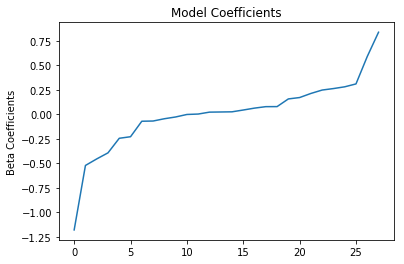

In [18]:
beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.title('Model Coefficients')
plt.ylabel('Beta Coefficients')
plt.show()

In [19]:
trainingSummary = lrModel.summary
print('Training set are under ROC curve: ' + str(trainingSummary.areaUnderROC))

Training set are under ROC curve: 0.8417377148090877


**ROC Curve**

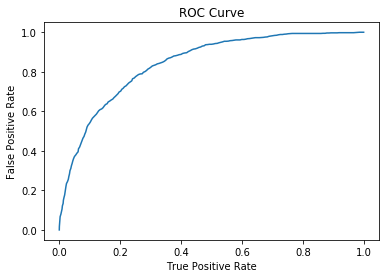

In [20]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

**Precision vs Recall Rate**

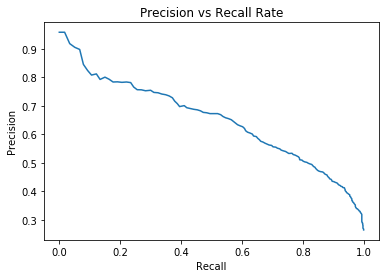

In [21]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall Rate')
plt.show()

**F1 Score**

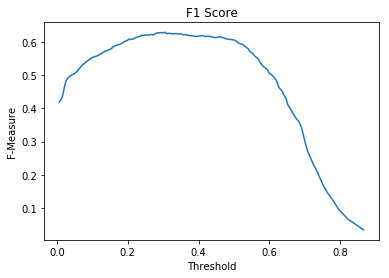

In [22]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.title('F1 Score')
plt.show()

### Prediction on test data

In [23]:
# Make predictions on test data using the Transformer.transform() method.
predictions = lrModel.transform(testData)
evaluator = BinaryClassificationEvaluator()
# Evaluate best model
accuracy = evaluator.evaluate(predictions)

In [24]:
print('Accuracy on test data:', accuracy)

Accuracy on test data: 0.8306447605073841


In [25]:
# View Best model's predictions and probabilities of each prediction class
selectedlr = predictions.select("label", "prediction", "probability")
selectedlr.createOrReplaceTempView("selectedlr")

** Create and Print Confusion Matrix**

In [26]:
confusion_matrixlr = spark.sql (""" 
select count(*), label, prediction
from selectedlr
group by label, prediction 
""")

In [27]:
confusion_matrixlr.show()

+--------+-----+----------+
|count(1)|label|prediction|
+--------+-----+----------+
|     296|  1.0|       1.0|
|     166|  0.0|       1.0|
|     260|  1.0|       0.0|
|    1354|  0.0|       0.0|
+--------+-----+----------+

